In [611]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.ardl import ARDL
from sklearn.model_selection import TimeSeriesSplit

In [612]:
goods_df = pd.read_csv("../data/global_commodity_prices.csv")
goods_df["Date"] = pd.to_datetime(goods_df["Date"], format='%m/%Y')

In [614]:
X = sm.add_constant(goods_df[["Tea", "Sugar"]])
Y = goods_df["Coffee"]

model = sm.OLS(Y, X).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for Tea: {model.params["Tea"]}")
print(f"Coefficient for sugar (PSUGAISAUSDM): {model.params["Sugar"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:                 Coffee   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     336.3
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           7.49e-88
Time:                        13:55:53   Log-Likelihood:                -189.31
No. Observations:                 422   AIC:                             384.6
Df Residuals:                     419   BIC:                             396.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0248      0.079      0.313      0.7

In [615]:
brl_df = pd.read_csv("../data/brl_data_clean.csv")
vnd_df = pd.read_csv("../data/vnd_data_clean.csv")
cop_df = pd.read_csv("../data/cop_data_clean.csv")
idr_df = pd.read_csv("../data/idr_data_clean.csv")
hnl_df = pd.read_csv("../data/hnl_data_clean.csv")

xr_df = brl_df
for df in [vnd_df, cop_df, idr_df, hnl_df]:
    xr_df = pd.merge(xr_df, df, on="Date", how="inner")
xr_df

,Date,brl Exchange Rate,vnd Exchange Rate,cop Exchange Rate,idr Exchange Rate,hnl Exchange Rate
0,01/01/1990,0.000006,5479.329529,440.08,1804.850000,2.0000
1,02/01/1990,0.000010,5479.329529,451.72,1809.870000,2.0000
2,03/01/1990,0.000016,5479.329529,463.40,1820.350000,4.0000
3,04/01/1990,0.000021,5479.329529,474.62,1826.050000,4.0000
4,05/01/1990,0.000023,5563.430866,485.99,1831.400000,4.2000
...,...,...,...,...,...,...
414,07/01/2024,5.541448,24251.560000,4036.80,16261.652826,24.8582
415,08/01/2024,5.552014,24245.850000,4062.98,15793.181818,24.8826
416,09/01/2024,5.540967,24163.540000,4191.86,15341.250000,24.8381
417,10/01/2024,5.623509,24192.520000,4257.76,15541.347826,24.9661


In [ ]:
goods_df = goods_df.rename(columns={'observation_date': 'Date'})

com_df3["Date"] = pd.to_datetime(com_df3["Date"], errors="coerce")
xr_df["Date"] = pd.to_datetime(xr_df["Date"], errors="coerce")

merge_df = pd.merge(com_df3, xr_df, on="Date", how="inner")

In [617]:
Z = sm.add_constant(merge_df[["PTEAUSDM", "PSUGAISAUSDM", "brl Exchange Rate", "vnd Exchange Rate", "cop Exchange Rate", 
                              "idr Exchange Rate", "hnl Exchange Rate"]])
W = merge_df["PCOFFOTMUSDM"]

model = sm.OLS(W, Z).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for tea (PTEAUSDM): {model.params["PTEAUSDM"]}")
print(f"Coefficient for sugar (PSUGAISAUSDM): {model.params["PSUGAISAUSDM"]}")
print(f"Coefficient for Brazil Exchange Rate: {model.params["brl Exchange Rate"]}")
print(f"Coefficient for Vietnam Exchange Rate: {model.params["vnd Exchange Rate"]}")
print(f"Coefficient for Colombia Exchange Rate: {model.params["cop Exchange Rate"]}")
print(f"Coefficient for Indonesia Exchange Rate: {model.params["idr Exchange Rate"]}")
print(f"Coefficient for Honduras Exchange Rate: {model.params["hnl Exchange Rate"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:           PCOFFOTMUSDM   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     138.7
Date:                Sun, 09 Mar 2025   Prob (F-statistic):          4.69e-104
Time:                        13:55:54   Log-Likelihood:                -2043.6
No. Observations:                 419   AIC:                             4103.
Df Residuals:                     411   BIC:                             4135.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                20.8993      9.88

In [618]:
result = adfuller(merge_df["PCOFFOTMUSDM"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -1.7881037917389915
P-Value: 0.3863836200932773


In [619]:
merge_df["coffee_diff"] = merge_df["PCOFFOTMUSDM"].diff()

merge_df["coffee_diff"] = merge_df["coffee_diff"].replace([np.inf, -np.inf], np.nan)

merge_df = merge_df.dropna(subset=["coffee_diff"])

In [620]:
result = adfuller(merge_df["coffee_diff"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -11.585252397877406
P-Value: 2.877944863354846e-21


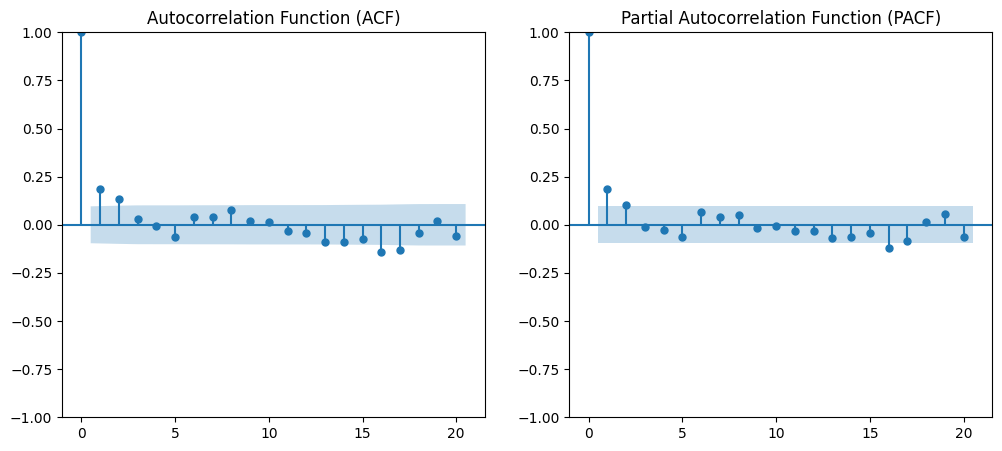

In [621]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

plot_acf(merge_df["coffee_diff"], lags=20, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(merge_df["coffee_diff"], lags=20, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [622]:
merge_df["Date"] = pd.to_datetime(merge_df["Date"])
merge_df.set_index("Date", inplace=True)
merge_df = merge_df.asfreq("ME")

In [623]:
model = ARIMA(merge_df['coffee_diff'], order=(1, 1, 1))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:            coffee_diff   No. Observations:                  417
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   0.000
Date:                Sun, 09 Mar 2025   AIC                              6.000
Time:                        13:55:54   BIC                             18.092
Sample:                    02-28-1990   HQIC                            10.781
                         - 10-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.0

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
c:\Users\nicol\AppData\Local\Programs\Python\Python31

C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\826739681.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=12, freq="M"), forecast, label="Forecast")


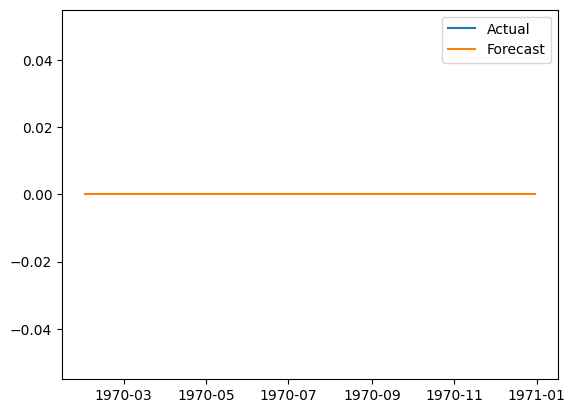

In [624]:
forecast = fitted_model.forecast(steps=12)
plt.plot(merge_df.index, merge_df["coffee_diff"], label="Actual")
plt.plot(pd.date_range(df.index[-1], periods=12, freq="M"), forecast, label="Forecast")
plt.legend()
plt.show()

In [625]:
mse = mean_squared_error(merge_df["coffee_diff"][-12:], forecast)
print(f"Mean Squared Error: {mse}")

ValueError: Input contains NaN.

In [ ]:
returns = merge_df['coffee_diff'].dropna()

garch_model = arch_model(merge_df['coffee_diff'].dropna(), vol='Garch', p=1, q=1)

garch_result = garch_model.fit()

print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1790.621818468854
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1888.518973009823
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1527.8438700180504
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1526.0592147593197
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1526.1306055619393
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1526.0355859457175
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1526.02795326455
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1526.0279327811622
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1526.0279327810304
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.0279327811622
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            coffee_diff   R-squared:          

In [ ]:
merge_df["tea_diff"] = merge_df["PTEAUSDM"].diff().dropna()
merge_df["tea_diff"].dropna(inplace=True)

merge_df["sugar_diff"] = merge_df["PSUGAISAUSDM"].diff().dropna()
merge_df["sugar_diff"].dropna(inplace=True)

merge_df["brl_diff"] = merge_df["brl Exchange Rate"].diff().dropna()
merge_df["brl_diff"].dropna(inplace=True)

merge_df["vnd_diff"] = merge_df["vnd Exchange Rate"].diff().dropna()
merge_df["vnd_diff"].dropna(inplace=True)

merge_df["cop_diff"] = merge_df["cop Exchange Rate"].diff().dropna()
merge_df["cop_diff"].dropna(inplace=True)

merge_df["idr_diff"] = merge_df["idr Exchange Rate"].diff().dropna()
merge_df["idr_diff"].dropna(inplace=True)

merge_df["hnl_diff"] = merge_df["hnl Exchange Rate"].diff().dropna()
merge_df["hnl_diff"].dropna(inplace=True)

In [ ]:
y = merge_df["coffee_diff"].dropna()
X = merge_df[["tea_diff", "sugar_diff", "brl_diff", "vnd_diff", "cop_diff", 
                              "idr_diff", "hnl_diff"]]

In [ ]:
model = ARDL(y, lags=(2, 2), exog=X)
model_fitted = model.fit()

print(model_fitted.summary())

MissingDataError: exog contains inf or nans